# Gaussian Process Tutorial Part 2: Kernels

The purpose of this notebook is to give an overview of the different kernel functions and how they are influenced by their hyperparameters. Towards the end, one should be able to get a feeling which kernels are appropriate for the structure in a given dataset.

In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import cm
from random import sample 
import pdb

sns.set_style('darkgrid')
np.random.seed(42)
#

In [2]:
class GPR():
   
    def __init__(self, kernel, optimizer='L-BFGS-B', noise_var=1e-8):
        self.kernel = kernel
        self.noise_var = noise_var
        self.optimizer = optimizer
    
        
    # 'Public' methods
    def sample_prior(self, X_test, n_samples=1):
        y_mean = np.zeros(X_test.shape[0])
        y_cov = self.kernel(X_test)
        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples)
    
    
    def sample_posterior(self, X_train, y_train, X_test, y_train_mean, y_test_mean, n_samples=1):
        # compute alpha
        # pdb.set_trace()
        K_aa = self.kernel(X_train)
        K_aa[np.diag_indices_from(K_aa)] += self.noise_var
        K_aa_inv = np.linalg.solve(K_aa, np.eye(K_aa.shape[0]))
        #L = self._cholesky_factorise(K_aa)
        #alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train)) # Forward/Backward-Solve

        # Compute posterior mean
        #K_trans = self.kernel(X_test, X_train)
        K_ba = self.kernel(X_test, X_train)
        alpha = K_ba.dot(K_aa_inv)
        y_mean = y_test_mean + alpha.dot(y_train-y_train_mean)
        #y_mean = K_trans.dot(alpha)

        # Compute posterior covariance
        K_bb=self.kernel(X_test)
        K_bb[np.diag_indices_from(K_bb)] += self.noise_var
        y_cov = K_bb - alpha.dot(K_ba.T) # K_ab = K_ba-T
        #v = np.linalg.solve(L, K_trans.T)  # L.T * K_inv * K_trans.T
        #y_cov = self.kernel(X_test) - np.dot(v.T, v)

        return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples), y_mean, y_cov
    
    #def sample_posterior(self, X_train, y_train, X_test, n_samples=1):
    #    # compute alpha
    #    K = self.kernel(X_train)
    #    K[np.diag_indices_from(K)] += self.noise_var
    #    L = self._cholesky_factorise(K)
    #    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    #    # Compute posterior mean
    #    K_trans = self.kernel(X_test, X_train)
    #    y_mean = K_trans.dot(alpha)

    #    # Compute posterior covariance
    #    v = np.linalg.solve(L, K_trans.T)  # L.T * K_inv * K_trans.T
    #    y_cov = self.kernel(X_test) - np.dot(v.T, v)

    #    return self._sample_multivariate_gaussian(y_mean, y_cov, n_samples), y_mean, y_cov
    
    
    def log_marginal_likelihood(self, X_train, y_train, theta, noise_var=None):
    
        if noise_var is None:
            noise_var = self.noise_var

        # Build K(X, X)
        self.kernel.theta = theta
        K = self.kernel(X_train)    
        K[np.diag_indices_from(K)] += noise_var

        # Compute L and alpha for this K (theta).
        L = self._cholesky_factorise(K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

        # Compute log marginal likelihood.
        log_likelihood = -0.5 * np.dot(y_train.T, alpha)
        log_likelihood -= np.log(np.diag(L)).sum()
        log_likelihood -= K.shape[0] / 2 * np.log(2 * np.pi)

        return log_likelihood
    
    
    def optimize(self, X_train, y_train):
    
        def obj_func(theta, X_train, y_train):
                return -self.log_marginal_likelihood(X_train, y_train, theta)

        results = minimize(obj_func, 
                           self.kernel.theta, 
                           args=(X_train, y_train), 
                           method=self.optimizer, 
                           jac=None,
                           bounds=self.kernel.bounds)

        # Store results of optimization.
        self.max_log_marginal_likelihood_value = -results['fun']
        self.kernel.theta_MAP = results['x']

        return results['success']
    
    
    # 'Private' helper methods
    def _cholesky_factorise(self, y_cov):
        try:
            L = np.linalg.cholesky(y_cov)
        except np.linalg.LinAlgError as e:
            e.args = ("The kernel, %s, is not returning a " 
                      "positive definite matrix. Try increasing"
                      " the noise variance of the GP or using"
                      " a larger value for epsilon. "
                      % self.kernel,) + e.args
            raise
        return L
    
    
    def _sample_multivariate_gaussian(self, y_mean, y_cov, n_samples=1, epsilon=1e-10):
        y_cov[np.diag_indices_from(y_cov)] += epsilon  # for numerical stability
        L = self._cholesky_factorise(y_cov)
        u = np.random.randn(y_mean.shape[0], n_samples)
        z = np.dot(L, u) + y_mean[:, np.newaxis]
        return z



## Kernels

OVERVIEW: Stationary vs. Non-Stationary, Isotropic, ...

In [3]:
class WhiteNoise():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.dot(X1, X1.T)
        else:
            K = self.theta[0] * np.dot(X1, X2.T)
        return K

class Linear():
    def __init__(self, signal_variance=1.0, signal_variance_bounds=(1e-5, 1e5)):
        self.theta = [signal_variance]
        self.bounds = [signal_variance_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            K = self.theta[0] * np.dot(X1, X1.T)
        else:
            K = self.theta[0] * np.dot(X1, X2.T)
        return K
    

class SquaredExponential():
    def __init__(self, length_scale=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, sigma]
        self.bounds = [length_scale_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0], X2 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        return self.theta[1]*K


class RationalQuadratic():
    def __init__(self, length_scale=1.0, alpha=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5), alpha_bounds=(1e-5,1e5)):
        self.theta = [length_scale, alpha, sigma]
        self.bounds = [length_scale_bounds, alpha_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), X2 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
        return self.theta[2]*K
    

class Periodic():
    def __init__(self, length_scale=1.0, period=1.0, sigma=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, period, sigma]
        self.bounds = [frequency_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
        return self.theta[2]*K
    
#class Matern():
#    def __init__(self, length_scale=1.0, frequency=1.0, frequency_bounds=(1e-5, 1e5)):
#        self.theta = [length_scale, frequency]
#        self.bounds = [frequency_bounds]
#    def __call__(self, X1, X2=None):
#        if X2 is None:
#            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
#            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#            K = squareform(K)
#            np.fill_diagonal(K, 1)
#        else:
#            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
#                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
#            K = np.exp(-2*dists)
#        return K

In [4]:
class add_Kernels():
    def __init__(self, k1, k2):
        self.kernel1 = k1
        self.kernel2 = k2
    
    def __call__(self, X1, X2=None):
        K = self.kernel1(X1, X2) + self.kernel2(X1, X2)
        return K
    
class mult_Kernels():
    def __init__(self, k1, k2):
        self.kernel1=k1
        self.kernel2=k2
    
    def __call__(self, X1, X2=None):
        K = self.kernel1(X1, X2) * self.kernel2(X1, X2)
        return K


In [5]:
# Plotting function to be used below

def plot_kernel(X, y, Sigma, description, fig, subplot_spec, xlim,
                scatter=False, rotate_x_labels=False):
    """Plot kernel matrix and samples."""
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        wspace=0.18, hspace=0.0,
        subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(grid_spec[0])
    ax2 = fig.add_subplot(grid_spec[1])
    # Plot samples
    if scatter:
        for i in range(y.shape[1]):
            ax1.scatter(X, y[:,i], alpha=0.8, s=3)
    else:
        for i in range(y.shape[1]):
            ax1.plot(X, y[:,i], alpha=0.8)
    ax1.set_ylabel('$y$', fontsize=13, labelpad=0)
    ax1.set_xlabel('$x$', fontsize=13, labelpad=0)
    ax1.set_xlim(xlim)
    if rotate_x_labels:
        for l in ax1.get_xticklabels():
            l.set_rotation(30)
    ax1.set_title(f'Samples from {description}')
    
    # Plot covariance matrix
    im = ax2.imshow(Sigma, cmap=cm.jet)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.02)
    cbar = plt.colorbar(im, ax=ax2, cax=cax)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=8)
    ax2.set_title(f'Covariance matrix\n{description}')
    ax2.set_xlabel('X', fontsize=10, labelpad=0)
    ax2.set_ylabel('X', fontsize=10, labelpad=0)
    
    # Show 5 custom ticks on x an y axis of covariance plot
    nb_ticks = 5
    ticks = list(range(xlim[0], xlim[1]+1))
    ticks_idx = np.rint(np.linspace(
        1, len(ticks), num=min(nb_ticks,len(ticks)))-1).astype(int)
    ticks = list(np.array(ticks)[ticks_idx])
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)
    if rotate_x_labels:
        for l in ax2.get_xticklabels():
            l.set_rotation(30)
    ax2.grid(False)
# 


In [6]:
global_fig_width = 14

### Linear Kernel

In [7]:
k1 = Linear(signal_variance=1.)
k2 = Linear(signal_variance=1.)
k3 = Linear(signal_variance=1.)

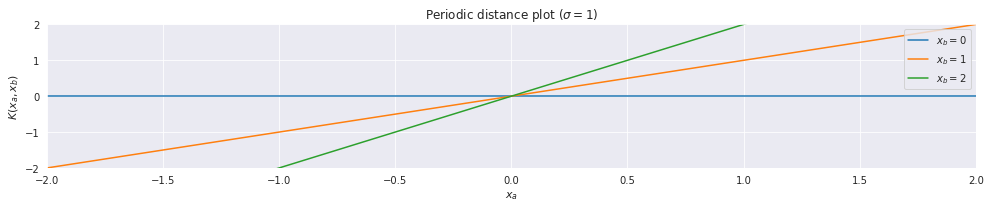

In [8]:
# Plot periodic distance
xlim = (-2, 2)
ylim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])
one = np.array([[1.]])
two = np.array([[2.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp = GPR(kernel = k1)
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$x_b=0$')

gp = GPR(kernel = k2)
Sigma = gp.kernel(one, X)
ax.plot(X[:,0], Sigma[0,:], label='$x_b=1$')

gp = GPR(kernel = k3)
Sigma = gp.kernel(two, X)
ax.plot(X[:,0], Sigma[0,:], label='$x_b=2$')

ax.set_xlabel('$x_a$', fontsize=11)
ax.set_ylabel('$K(x_a, x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

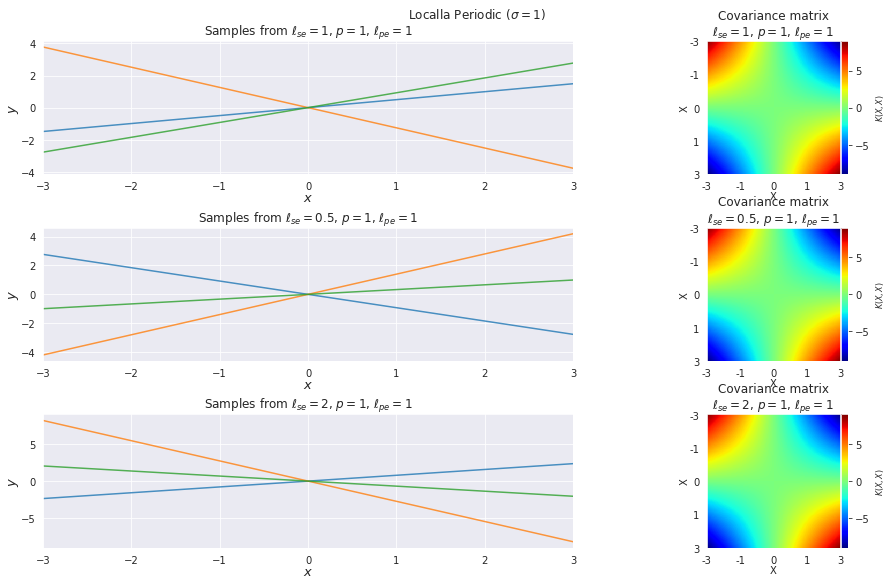

In [9]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first

gp1 = GPR(kernel = k1)
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second

gp2 = GPR(kernel = k2)
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
gp3 = GPR(kernel = k3)
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### Squared Exponential Kernel

\begin{align*}
k(\mathbf{x}_i, \mathbf{x}_j) = \sigma^{2}\text{exp} \left(-\frac{(\mathbf{x}_i - \mathbf{x}_j)^T (\mathbf{x}_i - \mathbf{x}_j)}{2\ell^{2}}\right)        \end{align*}

In [10]:
class SquaredExponential():
    def __init__(self, length_scale=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, sigma]
        self.bounds = [length_scale_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0], X2 / self.theta[0], metric='sqeuclidean')
            K = np.exp(-0.5 * dists)
            
        return self.theta[1]*K

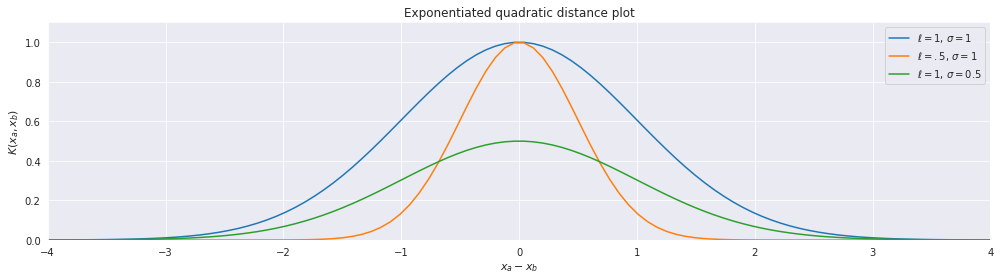

In [11]:
# Plot exponentiated quadratic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 4))

gp=GPR(kernel = SquaredExponential(length_scale=1, sigma=1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell = 1$, $\\sigma = 1$')

gp=GPR(kernel = SquaredExponential(length_scale=0.5, sigma=1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell = .5$, $\\sigma = 1$')

gp=GPR(kernel = SquaredExponential(length_scale=1.0, sigma=0.5))
Sigma = gp.kernel(zero, X)

ax.plot(X[:,0], Sigma[0,:], label='$\\ell = 1$, $\\sigma = 0.5$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Exponentiated quadratic distance plot')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

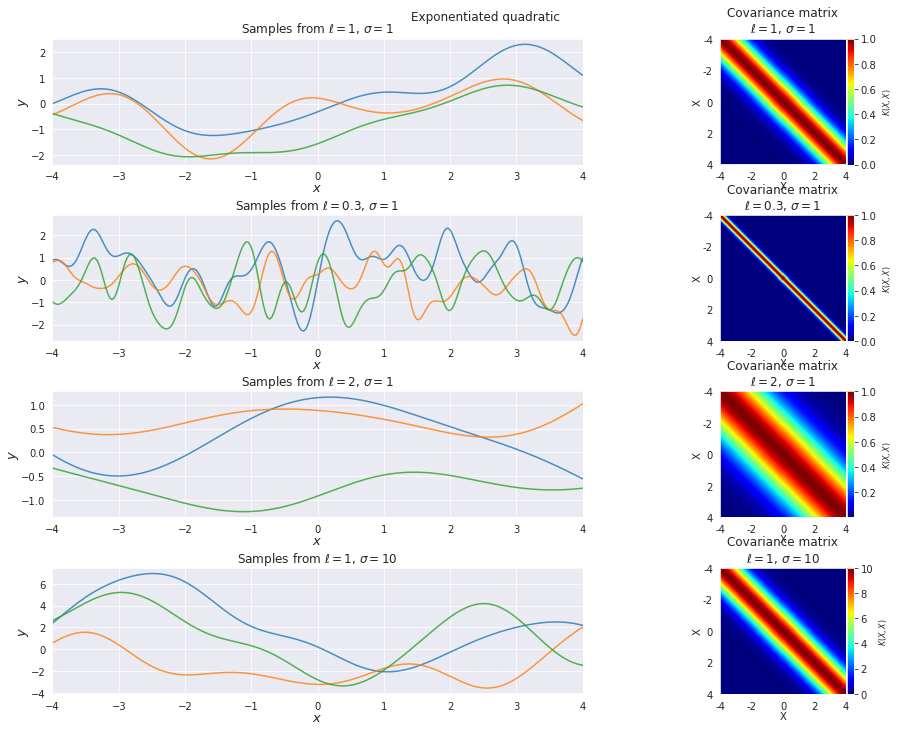

In [12]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 10)) 
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
gp=GPR(kernel = SquaredExponential(length_scale=1.0, sigma=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 1$, $\\sigma = 1$', 
    fig, gs[0], xlim)


# Plot second
gp=GPR(kernel = SquaredExponential(length_scale=0.2, sigma=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 0.3$, $\\sigma = 1$', 
    fig, gs[1], xlim)

# Plot third
gp=GPR(kernel = SquaredExponential(length_scale=2, sigma=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 2$, $\\sigma = 1$', 
    fig, gs[2], xlim)

# Plot fourth
gp=GPR(kernel = SquaredExponential(length_scale=1, sigma=10))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 1$, $\\sigma = 10$',  
    fig, gs[3], xlim)

plt.suptitle('Exponentiated quadratic', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.04, right=0.93, top=0.95)
plt.show()
#

### Rational Quadratic Kernel

\begin{align*}
k(\mathbf{x}_i, \mathbf{x}_j) = \sigma^{2}\left(1+ \frac{(\mathbf{x}_i - \mathbf{x}_j)^T (\mathbf{x}_i - \mathbf{x}_j)}{2\alpha \ell^{2}}\right)^{-\alpha}
\end{align*}


class RationalQuadratic():
    def __init__(self, length_scale=1.0, alpha=1.0, sigma=1.0, length_scale_bounds=(1e-5, 1e5), alpha_bounds=(1e-5,1e5)):
        self.theta = [length_scale, alpha, sigma]
        self.bounds = [length_scale_bounds, alpha_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1 / self.theta[0]*np.sqrt(self.theta[1]), X2 / self.theta[0]*np.sqrt(self.theta[1]), metric='sqeuclidean')
            K = (1 + dists)**(-self.theta[1])
        return self.theta[2]*K

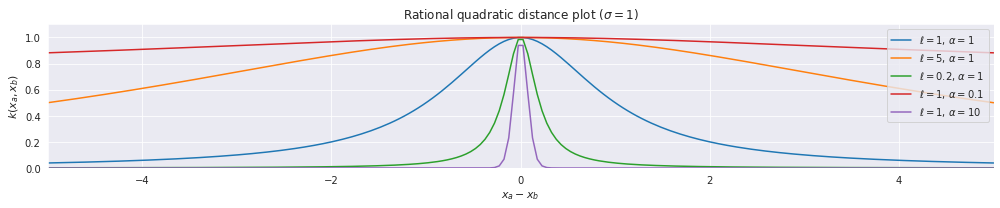

In [13]:
# Plot rational quadratic distance

xlim = (-5, 5)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))


gp=GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $\\alpha=1$')

gp=GPR(kernel = RationalQuadratic(length_scale=5.0, alpha=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=5$, $\\alpha=1$')

gp=GPR(kernel = RationalQuadratic(length_scale=0.2, alpha=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.2$, $\\alpha=1$')

gp=GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=0.1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $\\alpha=0.1$')

gp=GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=10))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $\\alpha=10$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$k(x_a,x_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

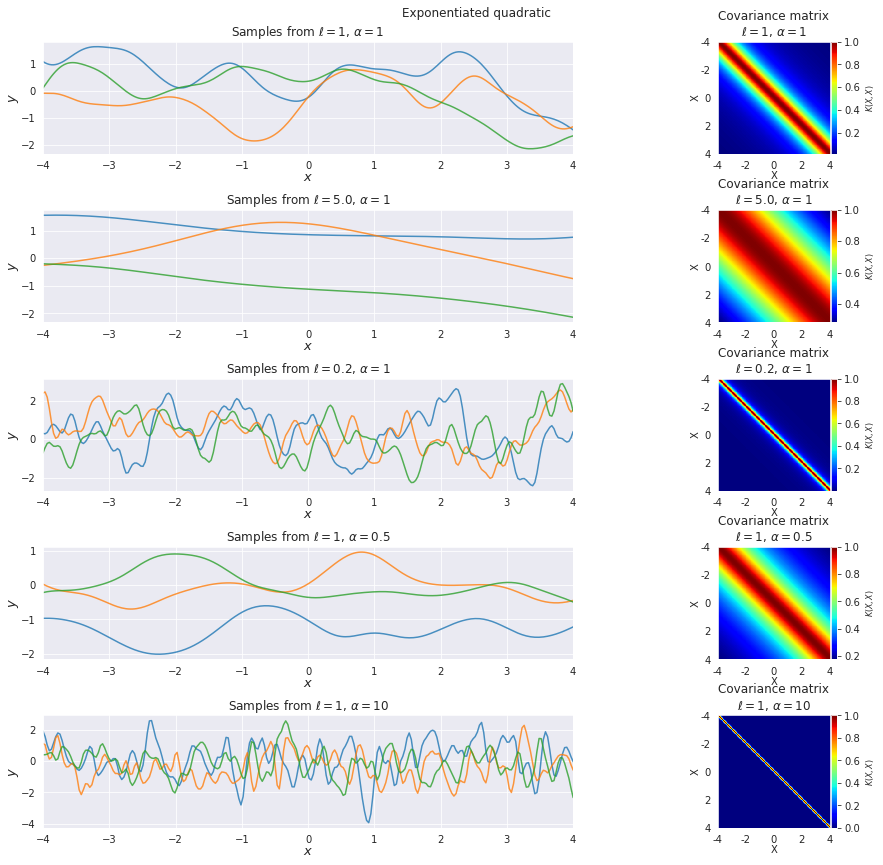

In [14]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 12)) 
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.5)

# Plot first
gp = GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 1$, $\\alpha = 1$', 
    fig, gs[0], xlim)


# Plot second
gp = GPR(kernel = RationalQuadratic(length_scale=5.0, alpha=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 5.0$, $\\alpha = 1$', 
    fig, gs[1], xlim)

# Plot third
gp = GPR(kernel = RationalQuadratic(length_scale=0.2, alpha=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 0.2$, $\\alpha = 1$', 
    fig, gs[2], xlim)

# Plot fourth
gp = GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=0.5))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 1$, $\\alpha = 0.5$',  
    fig, gs[3], xlim)

# Plot fifth
gp = GPR(kernel = RationalQuadratic(length_scale=1.0, alpha=10))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell = 1$, $\\alpha = 10$',  
    fig, gs[4], xlim)

plt.suptitle('Exponentiated quadratic', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.04, right=0.93, top=0.95)
plt.show()
#

## Periodic Kernel

\begin{align*}
k(\mathbf{x}_i, \mathbf{x}_j) = \sigma^{2}\text{exp}\left(- \frac{2}{\ell^2}\sin \left(\frac{\pi(\mathbf{x}_i - \mathbf{x}_j)}{p}\right)^T \sin \left(\frac{\pi (\mathbf{x}_i - \mathbf{x}_j)}{p}\right)\right)
\end{align*}    
    

In [15]:
class Periodic():
    def __init__(self, length_scale=1.0, period=1.0, sigma=1.0, frequency_bounds=(1e-5, 1e5)):
        self.theta = [length_scale, period, sigma]
        self.bounds = [frequency_bounds]
    def __call__(self, X1, X2=None):
        if X2 is None:
            # K(X1, X1) is symmetric so avoid redundant computation using pdist.
            dists = pdist(X1, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[1], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            dists = cdist(X1, X2, lambda xi, xj: np.dot(np.sin(np.pi * (xi - xj)/self.theta[1]).T/self.theta[0], 
                np.sin(np.pi * (xi - xj)/self.theta[1]))/self.theta[0])
            K = np.exp(-2*dists)
        return self.theta[2]*K

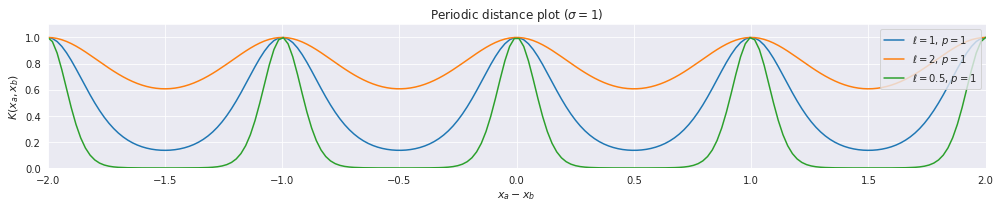

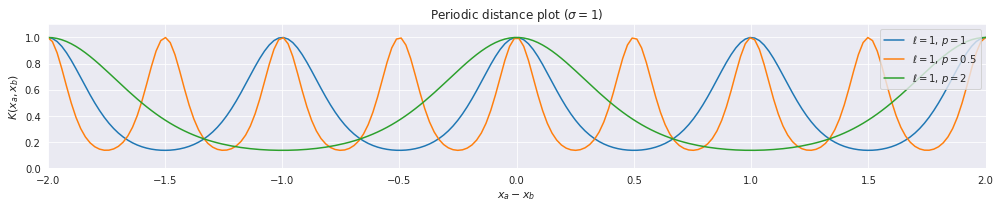

In [16]:
# Plot periodic distance

xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp=GPR(kernel = Periodic(length_scale=1.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

gp=GPR(kernel = Periodic(length_scale=2.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

gp=GPR(kernel = Periodic(length_scale=0.5, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()


# Second plot
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp=GPR(kernel = Periodic(length_scale=1, period=1.0, sigma=1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

gp=GPR(kernel = Periodic(length_scale=1.0, period=0.5, sigma=1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=0.5$')

gp=GPR(kernel = Periodic(length_scale=1.0, period=2, sigma=1))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=2$')
ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#


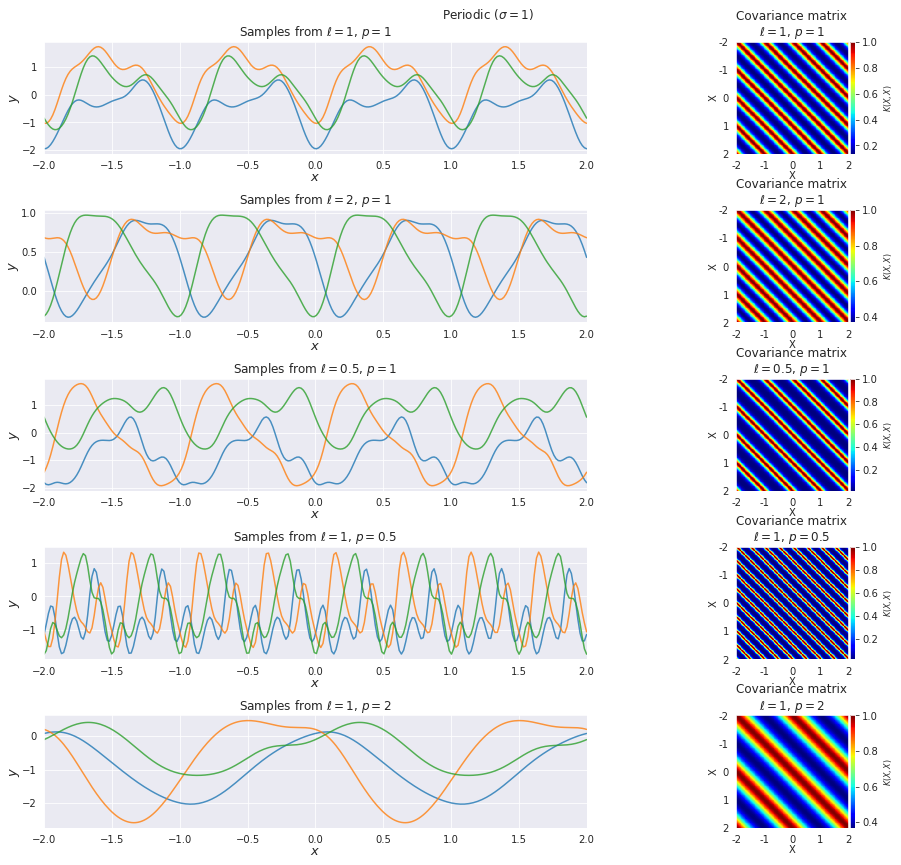

In [17]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 12)) 
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.5)

# Plot first
gp = GPR(kernel = Periodic(length_scale=1.0, period=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell=1$, $p=1$', 
    fig, gs[0], xlim)

# Plot second
gp = GPR(kernel = Periodic(length_scale=2.0, period=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell=2$, $p=1$', 
    fig, gs[1], xlim)

# Plot third
gp = GPR(kernel = Periodic(length_scale=0.5, period=1.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell=0.5$, $p=1$', 
    fig, gs[2], xlim)

# Plot fourth
gp = GPR(kernel = Periodic(length_scale=1, period=0.5))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell=1$, $p=0.5$', 
    fig, gs[3], xlim)

# Plot fifth
gp = GPR(kernel = Periodic(length_scale=1.0, period=2.0))
Sigma = gp.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell=1$, $p=2$',
    fig, gs[4], xlim)

fig.suptitle('Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Combination of Kernel

Kernels built by recursively combining one or more of the following rules are called well-defined kernels: 
\begin{align*}
& k(x,z)=x^{T}z\\
& k(x,z)=ck_{1}(x,z)\\
& k(x,z)=k_{1}(x,z)+k_{2}(x,z)\\
& k(x,z)=g(k(x,z))\\
& k(x,z)=k_{1}(x,z)k_{2}(x,z)\\
& k(x,z)=f(x)k_{1(}x,z)f(z)\\
& k(x,z)=\text{exp}\left(k_{1}(x,z)\right)\\
& k(x,z)=x^{T}Az
\end{align*}

where $k_{1}$,$k_{2}$ are well-defined kernels, $c\geq0$, $g$ is a polynomial function with positive coefficients, $f$ is any function and $A\geq0$ is a positive semi-definite Matrix. Kernel being well-defined is equivalent to the corresponding kernel matrix, K, being positive semidefinite, which is equivalent to any of the following statement:

- All eigenvalues of K are non-negative.
- $\exists$ real matrix P s.t. $K=P^{T}P$.
- $\forall$ real vector $x$, $x^{T}Kx \geq0$.

FOCUS ON ADDITION AND MULTIPLICATION OF RBF, LINEAR and PERIODIC

## Addition

### Linear + RBF 

In [18]:
k1 = add_Kernels(Linear(), SquaredExponential(length_scale=1.0))
k2 = add_Kernels(Linear(), SquaredExponential(length_scale=5.0))
k3 = add_Kernels(Linear(), SquaredExponential(length_scale=0.1))

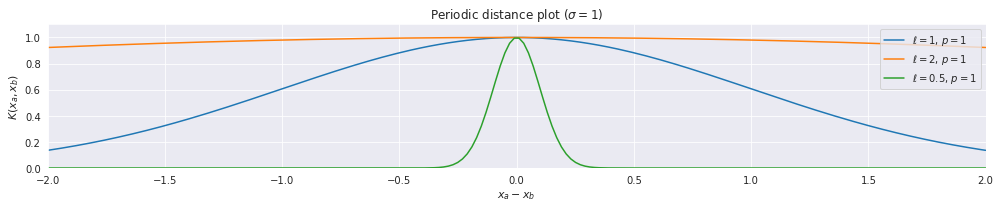

In [19]:
# Plot periodic distance
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp=GPR(kernel = k1)
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

gp=GPR(kernel = k2)
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

gp=GPR(kernel = k3)
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

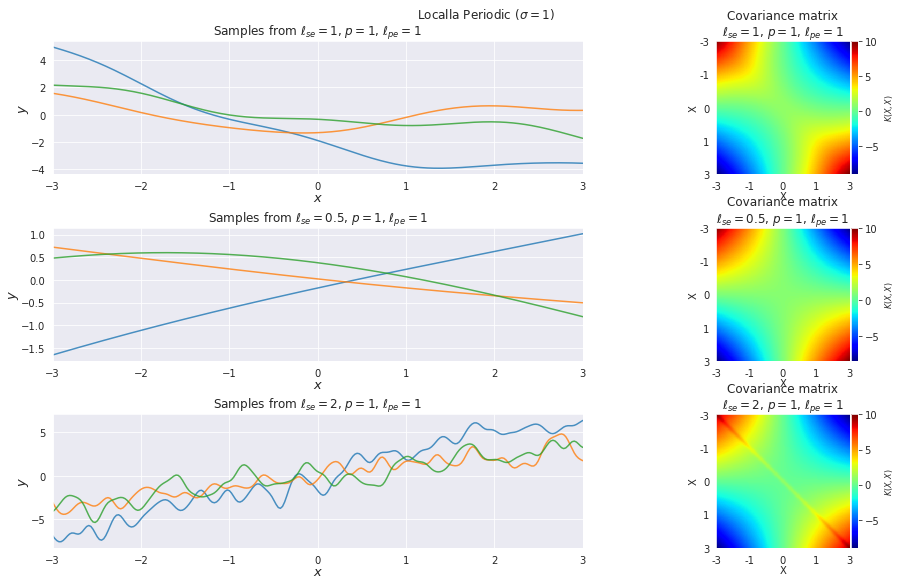

In [20]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first

gp1 = GPR(kernel = k1)
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second

gp2 = GPR(kernel = k2)
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
gp3 = GPR(kernel = k3)
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### Linear + Periodic 

In [21]:
k1 = add_Kernels(Linear(), Periodic(length_scale=1.0, period=1.0))
k2 = add_Kernels(Linear(), Periodic(length_scale=2.0, period=1.0))
k3 = add_Kernels(Linear(), Periodic(length_scale=0.5, period=1.0))

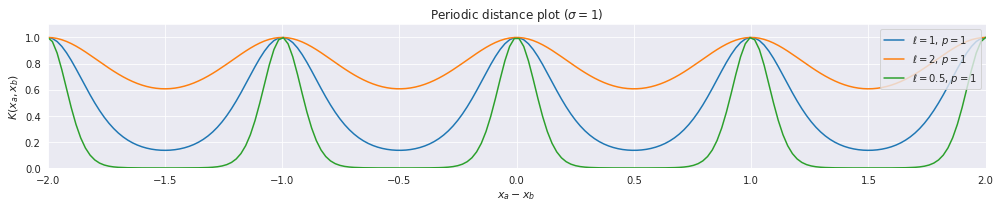

In [22]:
# Plot periodic distance

xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp1 = GPR(kernel = k1)
Sigma = gp1.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

gp2 = GPR(kernel = k2)
Sigma = gp2.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

gp3 = GPR(kernel = k3)
Sigma = gp3.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

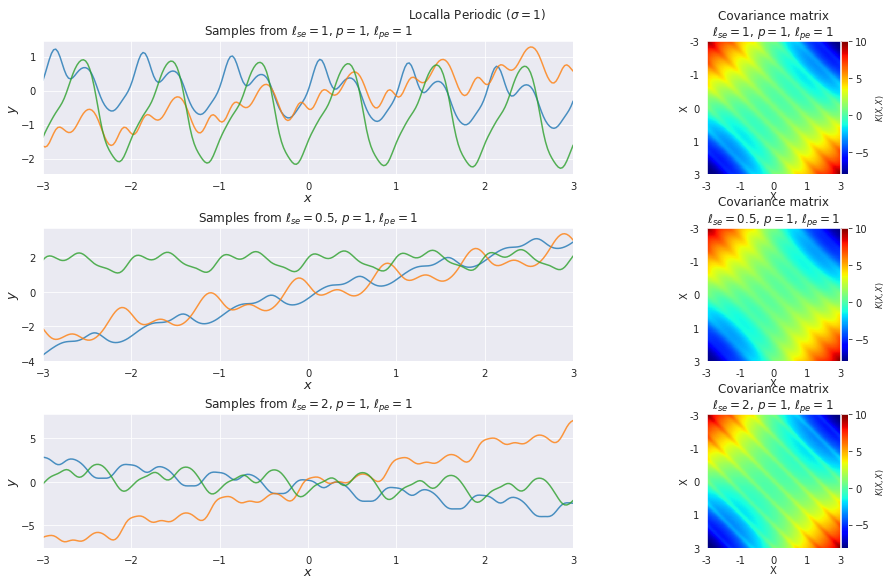

In [23]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first

gp1 = GPR(kernel = k1)
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second

gp2 = GPR(kernel = k2)
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
gp3 = GPR(kernel = k3)
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### RBF + Periodic 

In [24]:
k1 = add_Kernels(SquaredExponential(length_scale=1.0), Periodic(length_scale=1.0, period=1.0))
k2 = add_Kernels(SquaredExponential(length_scale=1.0), Periodic(length_scale=2.0, period=1.0))
k3 = add_Kernels(SquaredExponential(length_scale=1.0), Periodic(length_scale=0.5, period=1.0))

In [25]:
gp1 = GPR(kernel = k1)
gp2 = GPR(kernel = k2)
gp3 = GPR(kernel = k3)

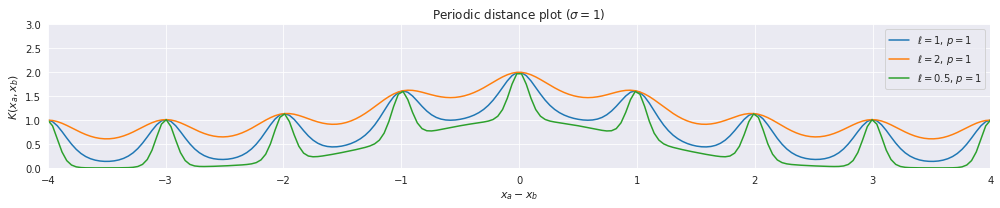

In [26]:
# Plot periodic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))


Sigma = gp1.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

Sigma = gp2.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

Sigma = gp3.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((0, 3))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

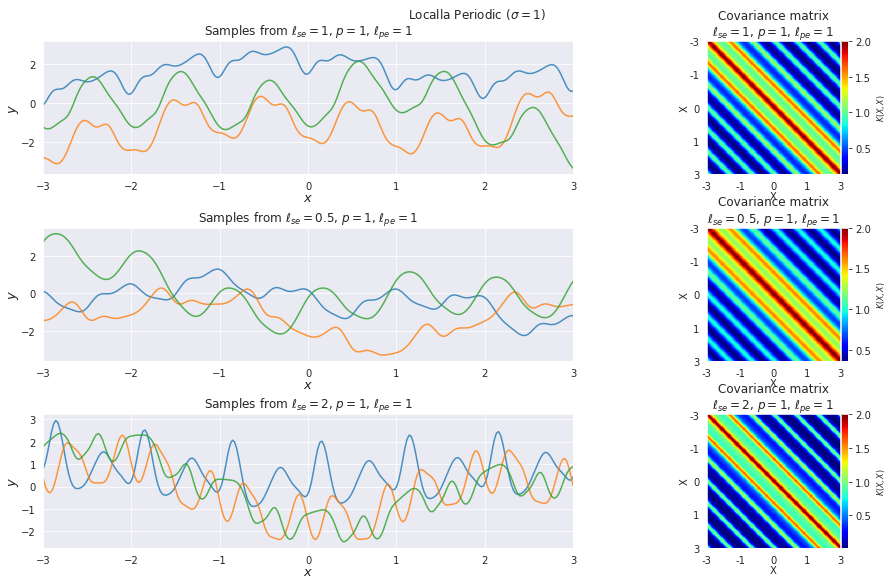

In [27]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first

gp1 = GPR(kernel = k1)
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second

gp2 = GPR(kernel = k2)
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
gp3 = GPR(kernel = k3)
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

## Multiplication

### Linear * RBF 

In [28]:
k1 = mult_Kernels(Linear(), SquaredExponential(length_scale=1.0))
k2 = mult_Kernels(Linear(), SquaredExponential(length_scale=2.0))
k3 = mult_Kernels(Linear(), SquaredExponential(length_scale=0.5))

In [29]:
gp1 = GPR(kernel = k1)
gp2 = GPR(kernel = k2)
gp3 = GPR(kernel = k3)

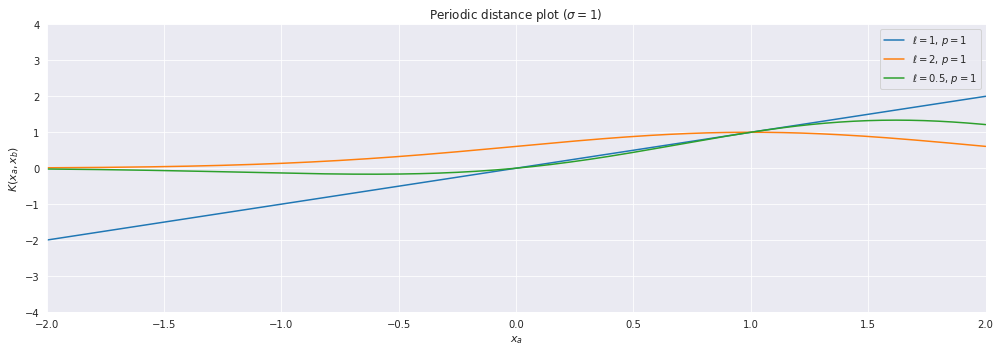

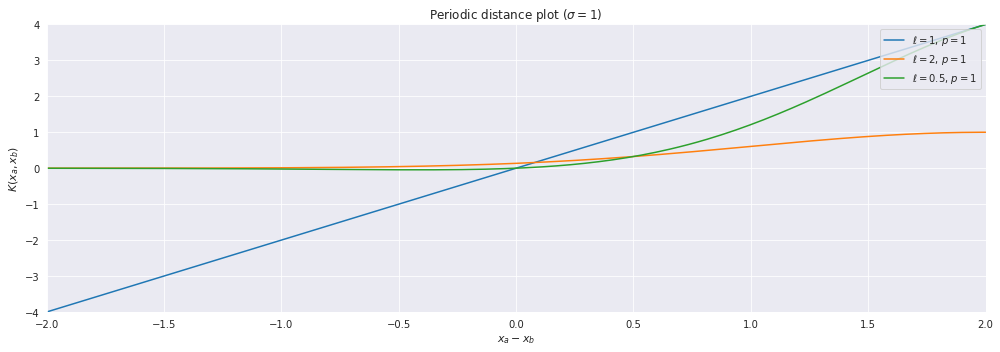

In [30]:
# Plot periodic distance

xlim = (-2, 2)
ylim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])
one = np.array([[1.]])
two = np.array([[2.]])

# First PLot
fig, ax = plt.subplots(figsize=(global_fig_width, 5))

gp1 = GPR(kernel = Linear())
Sigma = gp1.kernel(one, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

gp2 = GPR(kernel = SquaredExponential())
Sigma = gp2.kernel(one, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

gp3 = GPR(kernel = mult_Kernels(Linear(), SquaredExponential(length_scale=1.0)))
Sigma = gp3.kernel(one, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a$', fontsize=11)
ax.set_ylabel('$K(x_a, x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

# Second Plot
fig, ax = plt.subplots(figsize=(global_fig_width, 5))

gp1 = GPR(kernel = Linear())
Sigma = gp1.kernel(two, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')


gp2 = GPR(kernel = SquaredExponential())
Sigma = gp2.kernel(two, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')


gp3 = GPR(kernel = mult_Kernels(Linear(), SquaredExponential(length_scale=1.0)))
Sigma = gp3.kernel(two, X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

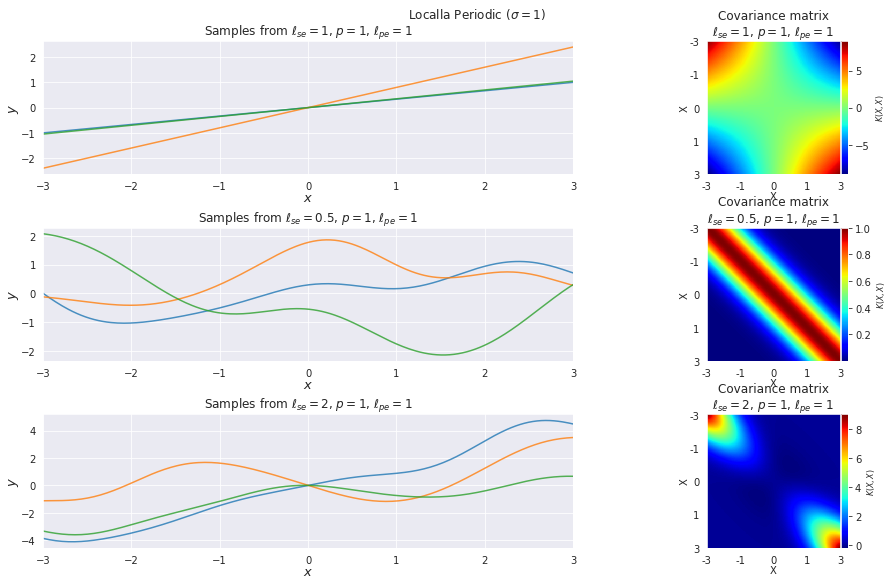

In [31]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### Linear * Periodic 

In [32]:
k1 = mult_Kernels(Linear(signal_variance = .1), Periodic(length_scale=1.0, period=1.0))
k2 = mult_Kernels(Linear(signal_variance = .1), Periodic(length_scale=2.0, period=1.0))
k3 = mult_Kernels(Linear(signal_variance = .1), Periodic(length_scale=0.1, period=1.0))

In [33]:
gp1 = GPR(kernel = k1)
gp2 = GPR(kernel = k2)
gp3 = GPR(kernel = k3)

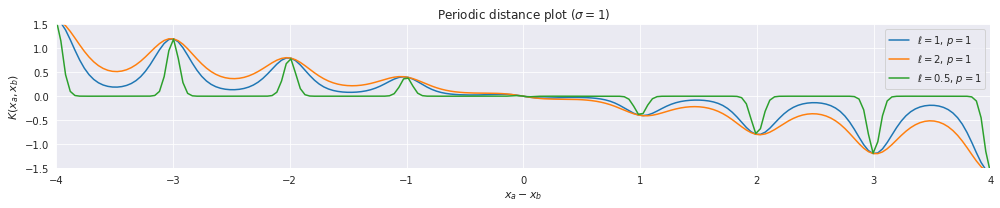

In [34]:
# Plot periodic distance

xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

Sigma = gp1.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

Sigma = gp2.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

Sigma = gp3.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((-1.5, 1.5))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

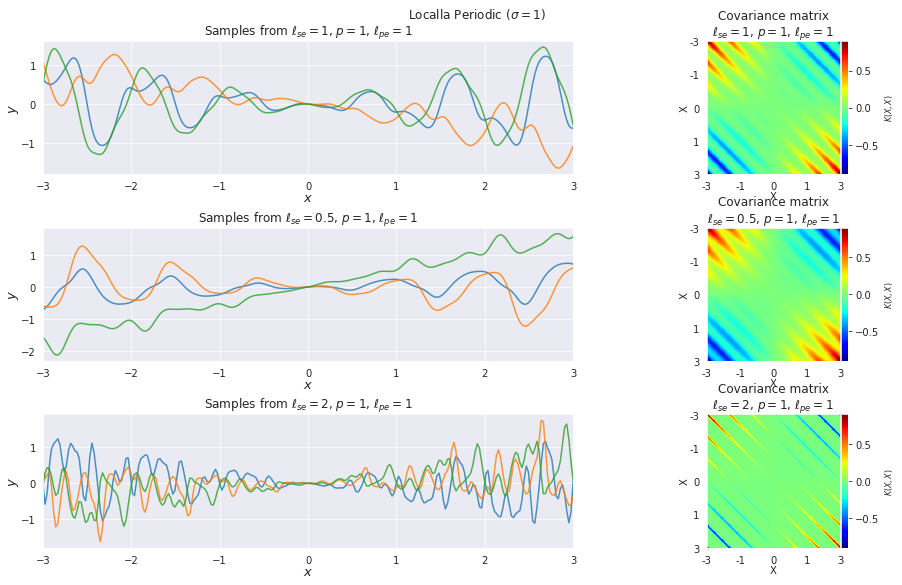

In [35]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### RBF * Periodic = Locally Periodic 

\begin{align*}
\quad &k(\mathbf{x}_i, \mathbf{x}_j) = k_{SE}*k_{Per}=\sigma^{2} \text{exp} \left(-\frac{(\mathbf{x}_i - \mathbf{x}_j)^T (\mathbf{x}_i - \mathbf{x}_j)}{2\ell^{2}}\right) 
\text{exp}\left(- \frac{2}{\ell^2}\sin \left(\frac{\pi(\mathbf{x}_i - \mathbf{x}_j)}{p}\right)^T \sin \left(\frac{\pi (\mathbf{x}_i - \mathbf{x}_j)}{p}\right)\right)
\end{align*}

In [36]:
k1 = mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=1.0))
k2 = mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=0.5))
k3 = mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=2.0))

In [37]:
gp1 = GPR(kernel = k1)
gp2 = GPR(kernel = k2)
gp3 = GPR(kernel = k3)

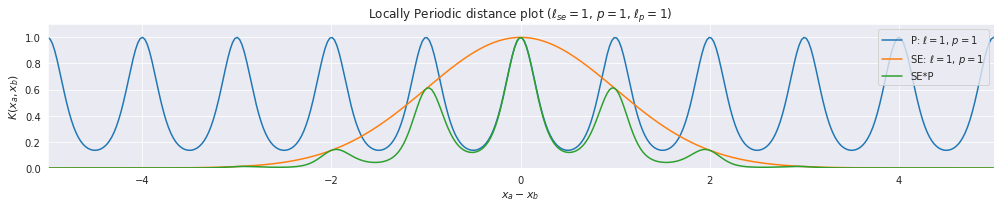

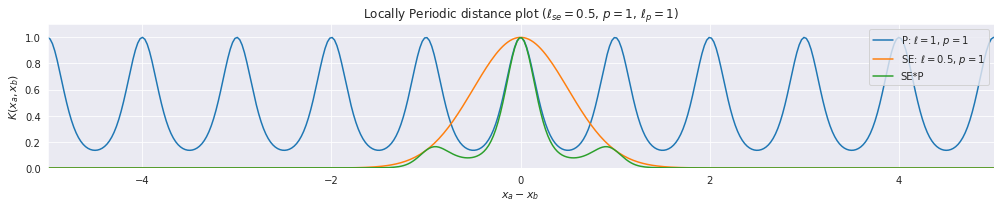

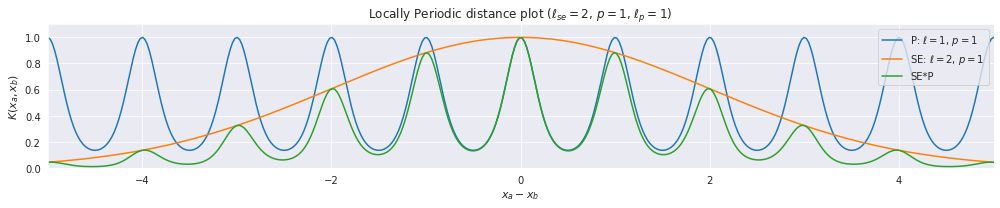

In [38]:
# Plot periodic distance

xlim = (-5, 5)
X = np.expand_dims(np.linspace(*xlim, num=400), 1)
zero = np.array([[0.]])

# First plot
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp = GPR(kernel = Periodic(length_scale=1.0,period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='P: $\\ell=1$, $p=1$')

gp = GPR(kernel = SquaredExponential(length_scale=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE: $\\ell=1$, $p=1$')


gp = GPR(kernel = mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=1.0))) #LocallyPeriodic(length_scale_se=1.0, sigma_se=1.0, length_scale_pe=1.0, sigma_pe=1.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE*P')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Locally Periodic distance plot ($\\ell_{se}=1$, $p=1$, $\\ell_{p}=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

# Second plot
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp = GPR(kernel = Periodic(length_scale=1.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='P: $\\ell=1$, $p=1$')

gp = GPR(kernel = SquaredExponential(length_scale=0.5))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE: $\\ell=0.5$, $p=1$')


gp = GPR(kernel = mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=0.5)))# LocallyPeriodic(length_scale_se=0.5, sigma_se=1.0, length_scale_pe=1.0, sigma_pe=1.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE*P')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Locally Periodic distance plot ($\\ell_{se}=0.5$, $p=1$, $\\ell_{p}=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

# Third plot
fig, ax = plt.subplots(figsize=(global_fig_width, 3))

gp = GPR(kernel=Periodic(length_scale=1.0,period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='P: $\\ell=1$, $p=1$')

gp = GPR(kernel=SquaredExponential(length_scale=2.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE: $\\ell=2$, $p=1$')

gp = GPR(kernel=mult_Kernels(Periodic(length_scale=1.0, period=1.0), SquaredExponential(length_scale=2.0)))#LocallyPeriodic(length_scale_se=2.0, sigma_se=1.0, length_scale_pe=1.0, sigma_pe=1.0, period=1.0))
Sigma = gp.kernel(zero, X)
ax.plot(X[:,0], Sigma[0,:], label='SE*P')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Locally Periodic distance plot ($\\ell_{se}=2$, $p=1$, $\\ell_{p}=1$)')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

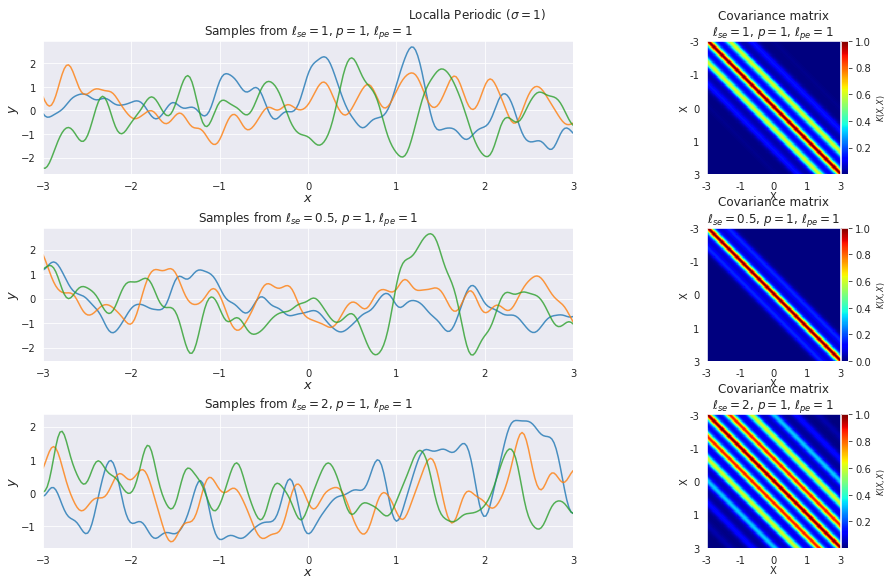

In [39]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 8)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#

### Linear * Linear

Linear Kernel is not stationary!!!

In [40]:
k1 = mult_Kernels(Linear(), Linear())
k2 = mult_Kernels(Linear(), k1)
k3 = mult_Kernels(Linear(), k2)

In [41]:
gp1 = GPR(kernel = k1)
gp2 = GPR(kernel = k2)
gp3 = GPR(kernel = k3)

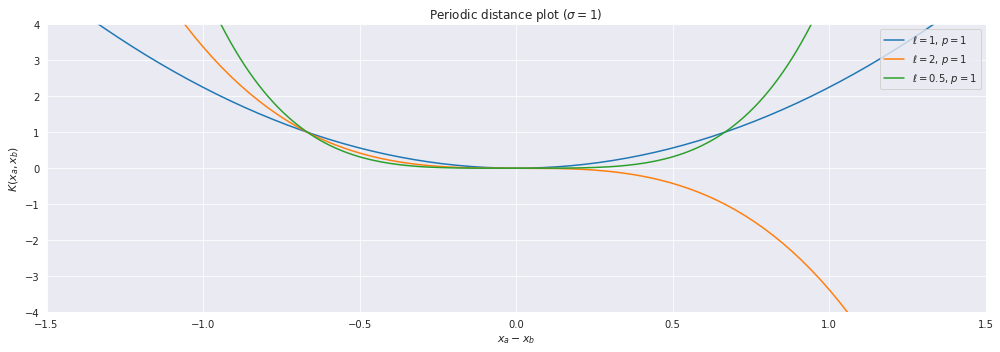

In [42]:
# Plot periodic distance

xlim = (-1.5, 1.5)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(global_fig_width, 5))

Sigma = gp1.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=1$, $p=1$')

Sigma = gp2.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=2$, $p=1$')

Sigma = gp3.kernel(X)
ax.plot(X[:,0], Sigma[0,:], label='$\\ell=0.5$, $p=1$')

ax.set_xlabel('$x_a - x_b$', fontsize=11)
ax.set_ylabel('$K(x_a,x_b)$', fontsize=11)
ax.set_title('Periodic distance plot ($\\sigma=1$)')
ax.set_ylim((-4, 4))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()
#

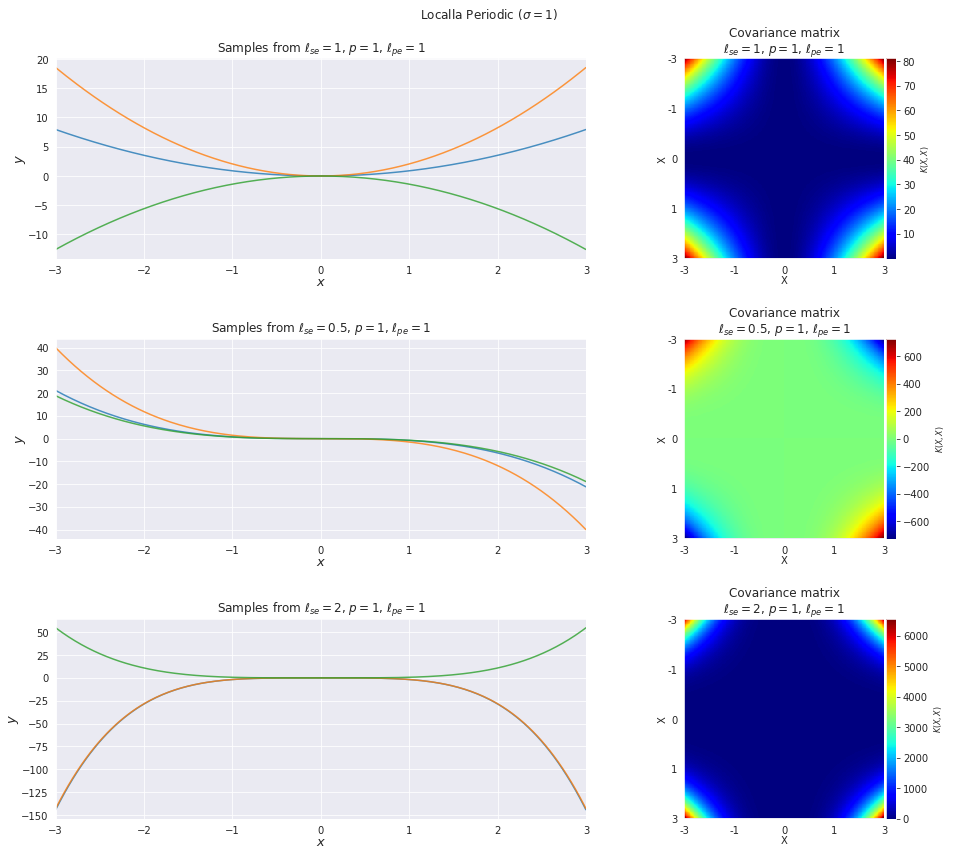

In [43]:
# Plot kernel matrix and samples of periodic

nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(global_fig_width, 12)) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Sigma = gp1.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=1$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[0], xlim)

# Plot second
Sigma = gp2.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=0.5$, $p=1$, $\\ell_{pe}=1$', 
    fig, gs[1], xlim)

# Plot third
Sigma = gp3.kernel(X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Sigma, '$\\ell_{se}=2$, $p=1$, $\\ell_{pe}=1$',  
    fig, gs[2], xlim)

fig.suptitle('Localla Periodic ($\\sigma=1$)', y=0.99)
fig.subplots_adjust(
    left=0.07, bottom=0.05, right=0.93, top=0.93)
plt.show()
#